## 加载数据集

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import Random
from collections import defaultdict

import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.data import DataLoader

from rdkit import Chem
from rdkit.Chem.BRICS import FindBRICSBonds
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger

In [2]:
# -------------------------------------
# attentive_fp fashion featurization
# -------------------------------------
def onehot_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return [x == s for s in allowable_set]


def onehot_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def atom_attr(mol, explicit_H=False, use_chirality=True, pharmaco=True, scaffold=True):
    if pharmaco:
        mol = tag_pharmacophore(mol)
    if scaffold:
        mol = tag_scaffold(mol)

    feat = []
    for i, atom in enumerate(mol.GetAtoms()):
        results = onehot_encoding_unk(
            atom.GetSymbol(),
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At', 'other'
             ]) + onehot_encoding_unk(atom.GetDegree(),
                                      [0, 1, 2, 3, 4, 5, 'other']) + \
                  [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                  onehot_encoding_unk(atom.GetHybridization(), [
                      Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                      Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                      Chem.rdchem.HybridizationType.SP3D2, 'other'
                  ]) + [atom.GetIsAromatic()]
        if not explicit_H:
            results = results + onehot_encoding_unk(atom.GetTotalNumHs(),
                                                    [0, 1, 2, 3, 4])
        if use_chirality:
            try:
                results = results + onehot_encoding_unk(
                    atom.GetProp('_CIPCode'),
                    ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
            # print(one_of_k_encoding_unk(atom.GetProp('_CIPCode'), ['R', 'S']) + [atom.HasProp('_ChiralityPossible')])
            except:
                results = results + [0, 0] + [atom.HasProp('_ChiralityPossible')]
        if pharmaco:
            results = results + [int(atom.GetProp('Hbond_donor'))] + [int(atom.GetProp('Hbond_acceptor'))] + \
                      [int(atom.GetProp('Basic'))] + [int(atom.GetProp('Acid'))] + \
                      [int(atom.GetProp('Halogen'))]
        if scaffold:
            results = results + [int(atom.GetProp('Scaffold'))]
        feat.append(results)

    return np.array(feat)


def bond_attr(mol, use_chirality=True):
    feat = []
    index = []
    n = mol.GetNumAtoms()
    for i in range(n):
        for j in range(n):
            if i != j:
                bond = mol.GetBondBetweenAtoms(i, j)
                if bond is not None:
                    bt = bond.GetBondType()
                    bond_feats = [
                        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                        bond.GetIsConjugated(),
                        bond.IsInRing()
                    ]
                    if use_chirality:
                        bond_feats = bond_feats + onehot_encoding_unk(
                            str(bond.GetStereo()),
                            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
                    feat.append(bond_feats)
                    index.append([i, j])

    return np.array(index), np.array(feat)


def bond_break(mol):
    results = np.array(sorted(list(FindBRICSBonds(mol))), dtype=np.long)

    if results.size == 0:
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(mol, asMols=True, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(mol)

    else:
        bond_to_break = results[:, 0, :]
        bond_to_break = bond_to_break.tolist()
        with Chem.RWMol(mol) as rwmol:
            for i in bond_to_break:
                rwmol.RemoveBond(*i)
        rwmol = rwmol.GetMol()
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(rwmol, asMols=True, sanitizeFrags=False, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(rwmol)
        cluster_idx = torch.LongTensor(cluster_idx)

    return fra_edge_index, fra_edge_attr, cluster_idx

In [3]:
# ---------------------------------------------
# Scaffold and pharmacophore information utils
# ---------------------------------------------
# tag pharmoco features to each atom
fun_smarts = {
        'Hbond_donor': '[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]',
        'Hbond_acceptor': '[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])]),n&X2&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]',
        'Basic': '[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))]),$([n;X2;+0;-0])]',
        'Acid': '[C,S](=[O,S,P])-[O;H1,-1]',
        'Halogen': '[F,Cl,Br,I]'
        }
FunQuery = dict([(pharmaco, Chem.MolFromSmarts(s)) for (pharmaco, s) in fun_smarts.items()])


def tag_pharmacophore(mol):
    for fungrp, qmol in FunQuery.items():
        matches = mol.GetSubstructMatches(qmol)
        match_idxes = []
        for mat in matches:
            match_idxes.extend(mat)
        for i, atom in enumerate(mol.GetAtoms()):
            tag = '1' if i in match_idxes else '0'
            atom.SetProp(fungrp, tag)
    return mol


# tag scaffold information to each atom
def tag_scaffold(mol):
    core = MurckoScaffold.GetScaffoldForMol(mol)
    match_idxes = mol.GetSubstructMatch(core)
    for i, atom in enumerate(mol.GetAtoms()):
        tag = '1' if i in match_idxes else '0'
        atom.SetProp('Scaffold', tag)
    return mol

In [4]:
# ---------------------------------
# data and dataset
# ---------------------------------
class MolData(Data):
    def __init__(self, fra_edge_index=None, fra_edge_attr=None, cluster_index=None, **kwargs):
        super(MolData, self).__init__(**kwargs)
        self.cluster_index = cluster_index
        self.fra_edge_index = fra_edge_index
        self.fra_edge_attr = fra_edge_attr

    def __inc__(self, key, value, *args, **kwargs):
        if key == 'cluster_index':
            return int(self.cluster_index.max()) + 1
        else:
            return super().__inc__(key, value, *args, **kwargs)


class MolDataset(InMemoryDataset):

    def __init__(self, root, dataset, task_type, tasks,
                 transform=None, pre_transform=None, pre_filter=None):

        self.tasks = tasks
        self.dataset = dataset
        self.task_type = task_type

        super(MolDataset, self).__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['{}.csv'.format(self.dataset)]

    @property
    def processed_file_names(self):
        return ['{}.pt'.format(self.dataset)]

    def download(self):
        pass

    def process(self):
        df = pd.read_csv(self.raw_paths[0])
        smilesList = df.smiles.values
        print(f'number of all smiles: {len(smilesList)}')
        remained_smiles = []
        canonical_smiles_list = []
        for smiles in smilesList:
            try:
                canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
                remained_smiles.append(smiles)
            except:
                print(f'not successfully processed smiles: {smiles}')
                pass
        print(f'number of successfully processed smiles: {len(remained_smiles)}')

        df = df[df["smiles"].isin(remained_smiles)].reset_index()
        target = df[self.tasks].values
        smilesList = df.smiles.values
        data_list = []

        for i, smi in enumerate(tqdm(smilesList)):

            mol = Chem.MolFromSmiles(smi)
            data = self.mol2graph(mol)

            if data is not None:
                label = target[i]
                data.y = torch.LongTensor([label])
                if self.task_type == 'regression':
                    data.y = torch.FloatTensor([label])
                data_list.append(data)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def mol2graph(self, mol):
        smiles = Chem.MolToSmiles(mol)
        if mol is None: return None
        node_attr = atom_attr(mol)
        edge_index, edge_attr = bond_attr(mol)
        fra_edge_index, fra_edge_attr, cluster_index = bond_break(mol)
        data = MolData(
            x=torch.FloatTensor(node_attr),
            edge_index=torch.LongTensor(edge_index).t(),
            edge_attr=torch.FloatTensor(edge_attr),
            fra_edge_index=torch.LongTensor(fra_edge_index).t(),
            fra_edge_attr=torch.FloatTensor(fra_edge_attr),
            cluster_index=torch.LongTensor(cluster_index),
            y=None,
            smiles=smiles,
        )
        return data

## 定义模型

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, Parameter, Bilinear

from torch_scatter import scatter
from torch_geometric.nn import global_add_pool, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, reset
from torch_geometric.nn.pool.pool import pool_batch
from torch_geometric.nn.pool.consecutive import consecutive_cluster

In [6]:
# ---------------------------------------
# Attention layers
# ---------------------------------------
class FeatureAttention(nn.Module):
    def __init__(self, channels, reduction):
        super().__init__()
        self.mlp = Sequential(
            Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            Linear(channels // reduction, channels, bias=False),
        )

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.mlp)

    def forward(self, x, batch, size=None):
        max_result = scatter(x, batch, dim=0, dim_size=size, reduce='max')
        sum_result = scatter(x, batch, dim=0, dim_size=size, reduce='sum')
        max_out = self.mlp(max_result)
        sum_out = self.mlp(sum_result)
        y = torch.sigmoid(max_out + sum_out)
        y = y[batch]
        return x * y

In [7]:
# ---------------------------------------
# Neural tensor networks conv
# ---------------------------------------
class NTNConv(MessagePassing):

    def __init__(self, in_channels, out_channels, slices, dropout, edge_dim=None, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(NTNConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.slices = slices
        self.dropout = dropout
        self.edge_dim = edge_dim

        self.weight_node = Parameter(torch.Tensor(in_channels,
                                                  out_channels))
        if edge_dim is not None:
            self.weight_edge = Parameter(torch.Tensor(edge_dim,
                                                      out_channels))
        else:
            self.weight_edge = self.register_parameter('weight_edge', None)

        self.bilinear = Bilinear(out_channels, out_channels, slices, bias=False)

        if self.edge_dim is not None:
            self.linear = Linear(3 * out_channels, slices)
        else:
            self.linear = Linear(2 * out_channels, slices)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight_node)
        glorot(self.weight_edge)
        self.bilinear.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):

        x = torch.matmul(x, self.weight_node)

        if self.weight_edge is not None:
            assert edge_attr is not None
            edge_attr = torch.matmul(edge_attr, self.weight_edge)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        alpha = self._alpha
        self._alpha = None

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_attr):
        score = self.bilinear(x_i, x_j)
        if edge_attr is not None:
            vec = torch.cat((x_i, edge_attr, x_j), 1)
            block_score = self.linear(vec)  # bias already included
        else:
            vec = torch.cat((x_i, x_j), 1)
            block_score = self.linear(vec)
        scores = score + block_score
        alpha = torch.tanh(scores)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        dim_split = self.out_channels // self.slices
        out = x_j.view(-1, self.slices, dim_split)

        out = out * alpha.view(-1, self.slices, 1)
        out = out.view(-1, self.out_channels)
        return out

    def __repr__(self):
        return '{}({}, {}, slices={})'.format(self.__class__.__name__,
                                              self.in_channels,
                                              self.out_channels, self.slices)

In [8]:
# ---------------------------------------
# HiGNN backbone
# ---------------------------------------
class HiGNN(torch.nn.Module):
    """Hierarchical informative graph neural network for molecular representation.

    """

    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers,
                 slices, dropout, f_att=False, r=4, brics=True, cl=False):
        super(HiGNN, self).__init__()

        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout

        self.f_att = f_att
        self.brics = brics
        self.cl = cl

        # atom feature transformation
        self.lin_a = Linear(in_channels, hidden_channels)
        self.lin_b = Linear(edge_dim, hidden_channels)

        # convs block
        self.atom_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = NTNConv(hidden_channels, hidden_channels, slices=slices,
                           dropout=dropout, edge_dim=hidden_channels)
            self.atom_convs.append(conv)

        self.lin_gate = Linear(3 * hidden_channels, hidden_channels)

        if self.f_att:
            self.feature_att = FeatureAttention(channels=hidden_channels, reduction=r)

        if self.brics:
            # mol-fra attention
            self.cross_att = GATConv(hidden_channels, hidden_channels, heads=4,
                                     dropout=dropout, add_self_loops=False,
                                     negative_slope=0.01, concat=False)

        if self.brics:
            self.out = Linear(2 * hidden_channels, out_channels)
        else:
            self.out = Linear(hidden_channels, out_channels)

        if self.cl:
            self.lin_project = Linear(hidden_channels, int(hidden_channels/2))

        self.reset_parameters()

    def reset_parameters(self):

        self.lin_a.reset_parameters()
        self.lin_b.reset_parameters()

        for conv in self.atom_convs:
            conv.reset_parameters()

        self.lin_gate.reset_parameters()

        if self.f_att:
            self.feature_att.reset_parameters()

        if self.brics:
            self.cross_att.reset_parameters()

        self.out.reset_parameters()

        if self.cl:
            self.lin_project.reset_parameters()

    def forward(self, data):
        # get mol input
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        x = F.relu(self.lin_a(x))  # (N, 46) -> (N, hidden_channels)
        edge_attr = F.relu(self.lin_b(edge_attr))  # (N, 10) -> (N, hidden_channels)

        # mol conv block
        for i in range(0, self.num_layers):
            h = F.relu(self.atom_convs[i](x, edge_index, edge_attr))
            beta = self.lin_gate(torch.cat([x, h, x - h], 1)).sigmoid()
            x = beta * x + (1 - beta) * h
            if self.f_att:
                x = self.feature_att(x, batch)

        mol_vec_ = global_add_pool(x, batch)
        mol_vec = global_add_pool(x, batch).relu_()

        if self.brics:
            # get fragment input
            fra_x = data.x
            fra_edge_index = data.fra_edge_index
            fra_edge_attr = data.fra_edge_attr
            cluster = data.cluster_index

            fra_x = F.relu(self.lin_a(fra_x))  # (N, 46) -> (N, hidden_channels)
            fra_edge_attr = F.leaky_relu_(self.lin_b(fra_edge_attr))  # (N, 10) -> (N, hidden_channels)

            # fragment convs block
            for i in range(0, self.num_layers):
                fra_h = F.relu(self.atom_convs[i](fra_x, fra_edge_index, fra_edge_attr))
                beta = self.lin_gate(torch.cat([fra_x, fra_h, fra_x - fra_h], 1)).sigmoid()
                fra_x = beta * fra_x + (1 - beta) * fra_h
                if self.f_att:
                    fra_x = self.feature_att(fra_x, cluster)

            fra_x_ = global_add_pool(fra_x, cluster)
            fra_x = global_add_pool(fra_x, cluster).relu_()

            # get fragment batch
            cluster, perm = consecutive_cluster(cluster)
            fra_batch = pool_batch(perm, data.batch)

            # molecule-fragment attention
            row = torch.arange(fra_batch.size(0), device=batch.device)
            mol_fra_index = torch.stack([row, fra_batch], dim=0)
            fra_vec, _ = self.cross_att((fra_x, mol_vec), mol_fra_index, return_attention_weights=False)
            fra_vec = fra_vec.relu()

            vectors_concat = list()
            vectors_concat.append(mol_vec)
            vectors_concat.append(fra_vec)

            out = torch.cat(vectors_concat, 1)
            
            mol_vec_ = mol_vec_[fra_batch]
            att = F.cosine_similarity(mol_vec_, fra_x_, dim=1), mol_fra_index

            # molecule-fragment contrastive
            if self.cl:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return self.out(out), self.lin_project(mol_vec).relu_(), self.lin_project(fra_vec).relu_()
            else:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return self.out(out), att

        else:
            assert self.cl is False
            out = F.dropout(mol_vec, p=self.dropout, training=self.training)
            return self.out(out)

## 加载模型

In [9]:
def load_best_result(model):
    best_ckpt_path = 'E:/3-Code/Jupternote book/HiGNN_Explainability/best_ckpt_bace_scaffold_seed2024.pth'
    ckpt = torch.load(best_ckpt_path, map_location=torch.device('cpu'))
    model.load_state_dict(ckpt['model'])

    return model

In [10]:
# ---------------------------------------
# Build HiGNN 
# ---------------------------------------
model = HiGNN(in_channels=46,
              hidden_channels=64,
              out_channels=2,
              edge_dim=10,
              num_layers=2,
              dropout=0.1,
              slices=4,
              f_att=True,
              r=4,
              brics=True,
              cl=False)

model = load_best_result(model)
print(model)

HiGNN(
  (lin_a): Linear(in_features=46, out_features=64, bias=True)
  (lin_b): Linear(in_features=10, out_features=64, bias=True)
  (atom_convs): ModuleList(
    (0): NTNConv(64, 64, slices=4)
    (1): NTNConv(64, 64, slices=4)
  )
  (lin_gate): Linear(in_features=192, out_features=64, bias=True)
  (feature_att): FeatureAttention(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=64, bias=False)
    )
  )
  (cross_att): GATConv(64, 64, heads=4)
  (out): Linear(in_features=128, out_features=2, bias=True)
)


## 骨架拆分

In [11]:
# ---------------------------------------------
# Scaffold utils, copy from chemprop.
# ---------------------------------------------
def generate_scaffold(mol, include_chirality=False):
    """
    Computes the Bemis-Murcko scaffold for a SMILES string.
    :param mol: A SMILES or an RDKit molecule.
    :param include_chirality: Whether to include chirality in the computed scaffold..
    :return: The Bemis-Murcko scaffold for the molecule.
    """
    mol = Chem.MolFromSmiles(mol) if type(mol) == str else mol
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)

    return scaffold


def scaffold_to_smiles(smiles, use_indices=False):
    """
    Computes the scaffold for each SMILES and returns a mapping from scaffolds to sets of smiles (or indices).
    :param smiles: A list of SMILES or RDKit molecules.
    :param use_indices: Whether to map to the SMILES's index in :code:`mols` rather than
                        mapping to the smiles string itself. This is necessary if there are duplicate smiles.
    :return: A dictionary mapping each unique scaffold to all SMILES (or indices) which have that scaffold.
    """
    scaffolds = defaultdict(set)
    for i, smi in enumerate(smiles):
        scaffold = generate_scaffold(smi)
        if use_indices:
            scaffolds[scaffold].add(i)
        else:
            scaffolds[scaffold].add(smi)

    return scaffolds


def scaffold_split(pyg_dataset, task_type, tasks, sizes=(0.8, 0.1, 0.1), balanced=True, seed=1):

    assert sum(sizes) == 1

    # Split
    print('generating scaffold......')
    num = len(pyg_dataset)
    train_size, val_size, test_size = sizes[0] * num, sizes[1] * num, sizes[2] * num
    train_ids, val_ids, test_ids = [], [], []
    train_scaffold_count, val_scaffold_count, test_scaffold_count = 0, 0, 0

    # Map from scaffold to index in the data
    scaffold_to_indices = scaffold_to_smiles(pyg_dataset.data.smiles, use_indices=True)

    # Seed randomness
    random = Random(seed)

    if balanced:  # Put stuff that's bigger than half the val/test size into train, rest just order randomly
        index_sets = list(scaffold_to_indices.values())
        big_index_sets = []
        small_index_sets = []
        for index_set in index_sets:
            if len(index_set) > val_size / 2 or len(index_set) > test_size / 2:
                big_index_sets.append(index_set)
            else:
                small_index_sets.append(index_set)
        random.seed(seed)
        random.shuffle(big_index_sets)
        random.shuffle(small_index_sets)
        index_sets = big_index_sets + small_index_sets
    else:  # Sort from largest to smallest scaffold sets
        index_sets = sorted(list(scaffold_to_indices.values()),
                            key=lambda index_set: len(index_set),
                            reverse=True)

    for index_set in index_sets:
        if len(train_ids) + len(index_set) <= train_size:
            train_ids += index_set
            train_scaffold_count += 1
        elif len(val_ids) + len(index_set) <= val_size:
            val_ids += index_set
            val_scaffold_count += 1
        else:
            test_ids += index_set
            test_scaffold_count += 1

    print(f'Total scaffolds = {len(scaffold_to_indices):,} | '
          f'train scaffolds = {train_scaffold_count:,} | '
          f'val scaffolds = {val_scaffold_count:,} | '
          f'test scaffolds = {test_scaffold_count:,}')

    print(f'Total smiles = {num:,} | '
          f'train smiles = {len(train_ids):,} | '
          f'val smiles = {len(val_ids):,} | '
          f'test smiles = {len(test_ids):,}')

    assert len(train_ids) + len(val_ids) + len(test_ids) == len(pyg_dataset)

    return train_ids, val_ids, test_ids

## 进行预测

In [12]:
path = 'E:/3-Code/Jupternote book/HiGNN_Explainability'
dataset = 'bace'
task_type = 'classification'
tasks = 'Class'
bace = MolDataset(root=path, dataset=dataset, task_type=task_type, tasks=tasks)
print(len(bace))

1513


In [13]:
train_ids, val_ids, test_ids = scaffold_split(bace, task_type, tasks, seed=2024)

generating scaffold......
Total scaffolds = 671 | train scaffolds = 533 | val scaffolds = 62 | test scaffolds = 76
Total smiles = 1,513 | train smiles = 1,210 | val smiles = 151 | test smiles = 152


In [14]:
df = pd.read_csv('./raw/bace.csv')
df

,smiles,Class
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,1
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,1
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,1
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,1
...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,0
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,0
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,0
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,0


In [15]:
loader = DataLoader(bace, batch_size=1600)
iter_ = iter(loader)
batch = next(iter_)

In [16]:
model.eval()  # 关闭dropout
output = model(batch)

In [17]:
output

(tensor([[ 0.0040,  0.6383],
         [-0.6110,  1.7857],
         [-0.8655,  1.7919],
         ...,
         [ 3.6077, -2.8154],
         [ 3.9109, -3.0062],
         [ 2.8584, -2.1096]], grad_fn=<AddmmBackward>),
 (tensor([0.3373, 0.1667, 0.3180,  ..., 0.3061, 0.4725, 0.8596],
         grad_fn=<DivBackward0>),
  tensor([[    0,     1,     2,  ..., 10927, 10928, 10929],
          [    0,     0,     0,  ...,  1512,  1512,  1512]])))

In [22]:
att = output[1][0].detach().numpy()
att

array([0.3373232 , 0.16671291, 0.31799367, ..., 0.3061027 , 0.47254848,
       0.85955113], dtype=float32)

In [23]:
cross = output[1][1].detach().numpy()
cross

array([[    0,     1,     2, ..., 10927, 10928, 10929],
       [    0,     0,     0, ...,  1512,  1512,  1512]], dtype=int64)

In [24]:
logits = output[0][:,1].detach().numpy()
logits

array([ 0.63834226,  1.7857199 ,  1.7919474 , ..., -2.8154206 ,
       -3.0061812 , -2.1096396 ], dtype=float32)

In [25]:
index = (logits).argsort()[0:10]
index

array([1504, 1425,  165, 1401, 1486, 1095, 1485, 1275, 1418, 1406],
      dtype=int64)

In [26]:
i = 1230

In [27]:
df.iloc[i]

smiles    Brc1cc(ccc1)C1(N=C(N2C1=NCC(F)(F)C2)N)c1ccc(OC...
Class                                                     0
pred                                                      0
Name: 1230, dtype: object

In [28]:
idx = cross[1]
num1 = np.where(idx==i)[0]
num1

array([9022, 9023, 9024, 9025], dtype=int64)

In [29]:
cross1 = cross[:,num1]
cross1

array([[9022, 9023, 9024, 9025],
       [1230, 1230, 1230, 1230]], dtype=int64)

In [30]:
att1 = att[num1]
att1

array([0.41911536, 0.92285657, 0.352442  , 0.47996303], dtype=float32)

In [31]:
smiles1 = df['smiles'].iloc[i]
smiles1

'Brc1cc(ccc1)C1(N=C(N2C1=NCC(F)(F)C2)N)c1ccc(OC)cc1'

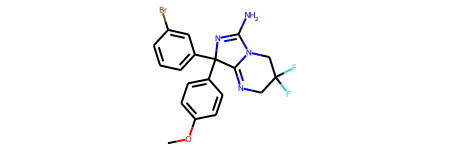

In [32]:
mol1 = Chem.MolFromSmiles(smiles1)
mol1

In [33]:
j = 677

In [34]:
df.iloc[j]

smiles    FC1(F)CN2C(=NC1)C(N=C2N)(c1cc(ccc1)C#CCCOC)c1c...
Class                                                     1
pred                                                      1
Name: 677, dtype: object

In [35]:
idx = cross[1]
num2 = np.where(idx==j)[0]
num2

array([5219, 5220, 5221, 5222, 5223], dtype=int64)

In [36]:
cross2 = cross[:,num2]
cross2

array([[5219, 5220, 5221, 5222, 5223],
       [ 677,  677,  677,  677,  677]], dtype=int64)

In [38]:
att2 = att[num2]
att2

array([0.8609098 , 0.80787927, 0.3073388 , 0.1525354 , 0.7005167 ],
      dtype=float32)

In [39]:
smiles2 = df['smiles'].iloc[j]
smiles2

'FC1(F)CN2C(=NC1)C(N=C2N)(c1cc(ccc1)C#CCCOC)c1ccc(OC(F)F)cc1'

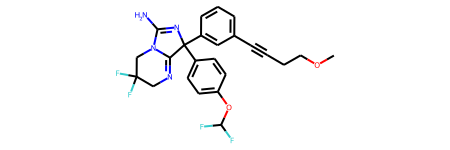

In [40]:
mol2 = Chem.MolFromSmiles(smiles2)
mol2

## 进行绘图

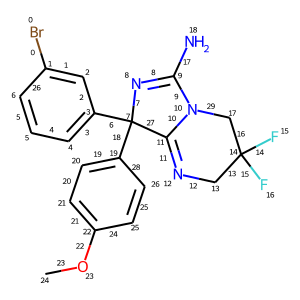

In [43]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
mol = mol1
drawer = rdMolDraw2D.MolDraw2DSVG(300,300)
drawer.drawOptions().addAtomIndices = True
drawer.drawOptions().addBondIndices = True
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
SVG(drawer.GetDrawingText())

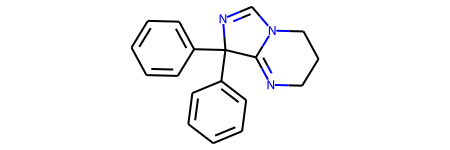

In [44]:
core = MurckoScaffold.GetScaffoldForMol(mol1)
core

In [45]:
from rdkit.Chem import AllChem
ms = [mol1, mol2]
AllChem.Compute2DCoords(core)
for m in ms:
    _ = AllChem.GenerateDepictionMatching2DStructure(m,core)

In [46]:
mol = mol2

RDKit ERROR: [21:37:45] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17


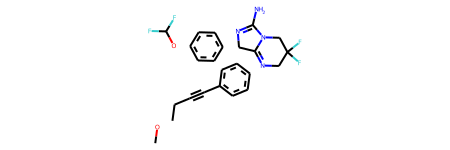

In [47]:
results = np.array(sorted(list(FindBRICSBonds(mol))), dtype=np.long)
bond_to_break = results[:, 0, :]
bond_to_break = bond_to_break.tolist()
with Chem.RWMol(mol) as rwmol:
    for i in bond_to_break:
        rwmol.RemoveBond(*i)
rwmol = rwmol.GetMol()
rwmol

In [48]:
results

array([[[ 8, 12],
        [13, 16]],

       [[ 8, 24],
        [13, 16]],

       [[22, 21],
        [ 3,  4]],

       [[28, 27],
        [ 3, 16]]])

In [49]:
cluster_idx = []
Chem.rdmolops.GetMolFrags(rwmol, asMols=True, sanitizeFrags=False, frags=cluster_idx)
cluster_idx

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 3,
 3]

In [50]:
atoms = mol.GetAtoms()
len(atoms)

34

In [51]:
hit_ats = list(range(0, len(atoms)))

In [52]:
weight_atom = att2[cluster_idx]
weight_atom = (weight_atom - weight_atom.min())/(weight_atom.max() - weight_atom.min())
weight_atom

array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       0.9251377, 0.9251377, 0.9251377, 0.9251377, 0.9251377, 0.9251377,
       0.9251377, 0.9251377, 0.9251377, 0.9251377, 0.2185333, 0.2185333,
       0.       , 0.       , 0.       , 0.       , 0.7735758, 0.7735758,
       0.7735758, 0.7735758, 0.       , 0.       ], dtype=float32)

In [53]:
hit_bonds = []
weight_bond = []
for bond in mol.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
    # 不是很严格
    if weight_atom[aid1] == weight_atom[aid2]:
        weight_bond.append(weight_atom[aid1])
    else:
        weight_bond.append(0)

In [54]:
weight_bond

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0,
 0.9251377,
 0.9251377,
 0.9251377,
 0.9251377,
 0.9251377,
 0.9251377,
 0.9251377,
 0.9251377,
 0.9251377,
 0,
 0.2185333,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0.7735758,
 0.7735758,
 0.7735758,
 0.0,
 0.0,
 1.0,
 0.9251377,
 0.0,
 1.0]

In [55]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

In [56]:
norm = matplotlib.colors.Normalize(vmin=0,vmax=1.28)
cmap = cm.get_cmap('Oranges')
plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)

atom_cols = {}
for at in hit_ats:
    atom_cols[at] = plt_colors.to_rgba(float(weight_atom[at]))
    
bond_cols = {}
for bd in hit_bonds:
    bond_cols[bd] = plt_colors.to_rgba(float(weight_bond[bd]))
# bond_cols[6] = (0, 0, 0, 0)
# bond_cols[18] = (0, 0, 0, 0)
# bond_cols[22] = (0, 0, 0, 0)
# # bond_cols[11] = (0, 0, 0, 0)

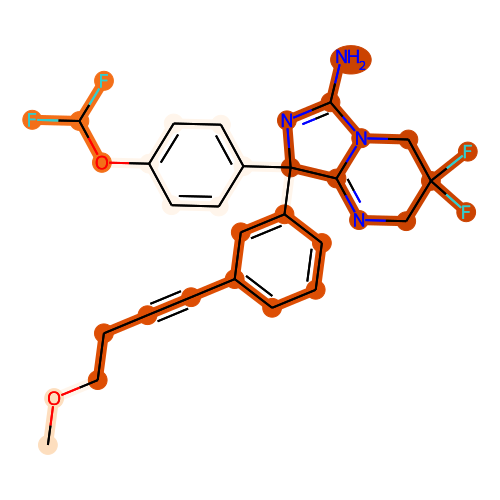

In [57]:
d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,
                                   highlightBonds=hit_bonds,
                                   highlightAtomColors=atom_cols,
                                   highlightBondColors=bond_cols)
d.DrawMolecule(mol)
d.FinishDrawing()
SVG(d.GetDrawingText())

In [58]:
with open('bace_709.svg', 'w+') as out:
    out.write(d.GetDrawingText())